In [9]:
import zipfile

zip_data = "../data/01_raw/archive.zip"
extract_to = "../data/02_intermediate/"

In [10]:
with zipfile.ZipFile(zip_data, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

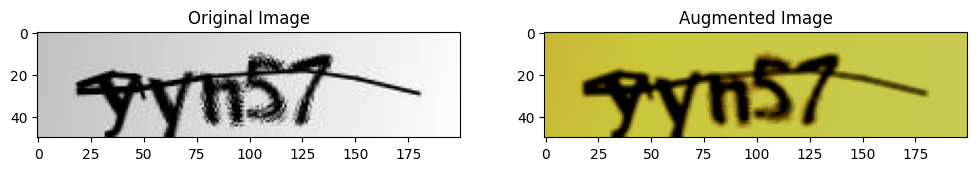

In [26]:
import cv2
import numpy as np
import albumentations as A
from matplotlib import pyplot as plt

# Define the augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=10),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.MultiplicativeNoise(multiplier=(0.5, 1.5))
    ], p=0.5),
    A.Blur(blur_limit=3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20)
])

# Load an example image (replace with your CAPTCHA image)
image = cv2.imread('../data/02_intermediate/archive/yyn57.png')

# Apply the augmentation
augmented_image = transform(image=image)['image']

# Display the original and augmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Augmented Image')
plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
plt.show()


In [30]:
import os
import random
import shutil
import logging
from tqdm import tqdm

def split_data(source_folder, destination, split_ratio=0.8, random_seed=42):
    random.seed(random_seed)

    all_files = os.listdir(source_folder)
    random.shuffle(all_files)
    num_train = int(len(all_files) * split_ratio)
    train_files = all_files[:num_train]
    val_files = all_files[num_train:]

    train_folder = os.path.join(destination, "train")
    val_folder = os.path.join(destination, "val")

    if os.path.exists(train_folder):
        shutil.rmtree(train_folder)
    if os.path.exists(val_folder):
        shutil.rmtree(val_folder)
 
    os.makedirs(train_folder)
    os.makedirs(val_folder)

    for file in tqdm(train_files, desc="Copying train data"):
        shutil.copy(os.path.join(source_folder, file), os.path.join(train_folder, file))

    for file in tqdm(val_files, desc="Copying validation data"):
        shutil.copy(os.path.join(source_folder, file), os.path.join(val_folder, file))


In [31]:
import os

split_data(os.path.join(extract_to, "archive"), "../data/03_primary")

Copying validation data: 100%|██████████| 214/214 [00:03<00:00, 63.89it/s]


In [46]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CAPTCHADataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        
    def __len__(self):
        return len(os.listdir(self.data_path))
    
    def __getitem__(self, index):
        image_fn = os.listdir(self.data_path)[index]
        image_fp = os.path.join(self.data_path, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])
        return transform_ops(image)

In [47]:
batch_size = 32
data_path = "../data/03_primary"

train_dataset = CAPTCHADataset(os.path.join(data_path, "train"))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [48]:
next(iter(train_loader))

[tensor([[[[1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
           [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
           [1.1700, 1.1700, 1.1700,  ..., 2.1804, 2.1804, 2.1804],
           ...,
           [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
           [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318],
           [1.2214, 1.2214, 1.2214,  ..., 2.2318, 2.2318, 2.2318]],
 
          [[1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
           [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
           [1.3256, 1.3256, 1.3256,  ..., 2.3585, 2.3585, 2.3585],
           ...,
           [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
           [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111],
           [1.3782, 1.3782, 1.3782,  ..., 2.4111, 2.4111, 2.4111]],
 
          [[1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
           [1.5420, 1.5420, 1.5420,  ..., 2.5703, 2.5703, 2.5703],
           [1.5420, 1.54

In [49]:
# Mapping characters to indices
char_to_index = {'-': 0}
for i in range(1, 10):
    char_to_index[str(i)] = i
for i, char in enumerate(range(ord('a'), ord('z') + 1), start=10):
    char_to_index[chr(char)] = i

# Mapping indices to characters
index_to_char = {index: char for char, index in char_to_index.items()}

# Example usage
print(char_to_index)  # {'-': 0, '1': 1, '2': 2, ..., 'a': 10, 'b': 11, ..., 'z': 35}
print(index_to_char)  # {0: '-', 1: '1', 2: '2', ..., 10: 'a', 11: 'b', ..., 35: 'z'}


{'-': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
{0: '-', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}


In [65]:
import torch
import torch.nn as nn
from torchvision.models import resnet18# , ResNet18_Weights

class CRNN(nn.Module):
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        resnet = resnet18(pretrained=True) # weights=ResNet18_Weights.IMAGENET1K_V1)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
    def forward(self, batch):
        batch = self.cnn_p1(batch)
        batch = self.cnn_p2(batch)
        batch = batch.permute(0, 3, 1, 2)
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1)
        batch = self.linear1(batch)
        batch, _ = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        batch, _ = self.rnn2(batch)
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [ ]:
# parser.add_argument("--hidden_size", type=int, default=256)
# parser.add_argument("--epochs", type=int, default=100)
# parser.add_argument("--batch_size", type=int, default=32)
# parser.add_argument("--learning_rate", type=float, default=0.001)
# parser.add_argument("--weight_decay", type=float, default=1e-3)
# parser.add_argument("--clip_norm", type=float, default=5)
# parser.add_argument("--drop_out", type=float, default=0.1)
# parser.add_argument("--patience", type=int, default=5)
# parser.add_argument("--random_seed", type=int, default=42)
# parser.add_argument("--split_ratio", type=float, default=0.8)

In [64]:
import torch.nn.functional as F

def compute_loss(text_batch, text_batch_logits, device, criterion, char_to_idx):
    text_batch_logps = F.log_softmax(text_batch_logits, 2)
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),),
                                       fill_value=text_batch_logps.size(0),
                                       dtype=torch.int32).to(device)
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch, char_to_idx)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss


def encode_text_batch(text_batch, char_to_idx):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)

    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char_to_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)

    return text_batch_targets, text_batch_targets_lens


def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx - 1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)


def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word


def decode_predictions(text_batch_logits, idx_to_char):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2)
    text_batch_tokens = text_batch_tokens.numpy().T

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx_to_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch import optim
import sys

hidden_size = 256
drop_out = 0.1
learning_rate = 0.001
weight_decay = 1e-3
patience = 5
epochs = 1
clip_norm = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

num_chars = 35
crnn = CRNN(num_chars, rnn_hidden_size=hidden_size, dropout=drop_out)
crnn.apply(weights_init)
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience)
criterion = nn.CTCLoss(blank=0)

Downloading: "https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth" to C:\Users\bharanishraj.ds/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:25<00:00, 1.82MB/s]


In [68]:
char_to_idx = {'-': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}
idx_to_char = {0: '-', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'b', 12: 'c', 13: 'd', 14: 'e', 15: 'f', 16: 'g', 17: 'h', 18: 'i', 19: 'j', 20: 'k', 21: 'l', 22: 'm', 23: 'n', 24: 'o', 25: 'p', 26: 'q', 27: 'r', 28: 's', 29: 't', 30: 'u', 31: 'v', 32: 'w', 33: 'x', 34: 'y', 35: 'z'}

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epochs: 100%|██████████| 1/1 [00:49<00:00, 49.12s/it]


Current learning rate: 0.001
2.9593124389648438 3.273237705230713 27


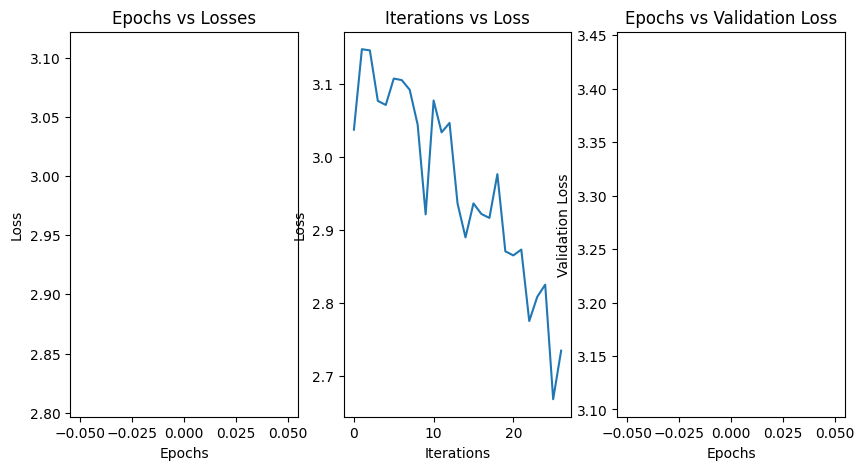

In [70]:
epoch_losses = []
iteration_losses = []
val_losses = []
num_updates_epochs = []

try:
    for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
        epoch_loss_list = [] 
        val_epoch_loss_list = []
        num_updates_epoch = 0
        
        for image_batch, text_batch in tqdm(train_loader, desc="Batches", leave=False):
            crnn.train()
            text_batch_logits = crnn(image_batch.to(device))
            loss = compute_loss(text_batch, text_batch_logits, device, criterion, char_to_idx)
            iteration_loss = loss.item()
            optimizer.zero_grad()

            if not torch.isfinite(loss):
                continue

            num_updates_epoch += 1
            iteration_losses.append(iteration_loss)
            epoch_loss_list.append(iteration_loss)

            loss.backward()
            nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
            optimizer.step()

            crnn.eval()
            with torch.no_grad():
                text_batch_logits = crnn(image_batch)
                text_batch_pred = decode_predictions(text_batch_logits.cpu(), idx_to_char)

                val_loss = compute_loss(text_batch, text_batch_logits, device, criterion, char_to_idx)
                iteration_val_loss = val_loss.item()
                val_epoch_loss_list.append(iteration_val_loss)


            accuracy = accuracy_score(text_batch, text_batch_pred)
            precision = precision_score(text_batch, text_batch_pred, average='weighted', zero_division=1)
            recall = recall_score(text_batch, text_batch_pred, average='weighted', zero_division=1)
            f1 = f1_score(text_batch, text_batch_pred, average='weighted')

            # mlflow.log_metric("Accuracy", accuracy)
            # mlflow.log_metric("Precision", precision)
            # mlflow.log_metric("Recall", recall)
            # mlflow.log_metric("F1-Score", f1)
            # mlflow.log_metric("Batch Loss", iteration_loss)

        epoch_loss = torch.tensor(epoch_loss_list).mean().item()
        val_loss = torch.tensor(val_epoch_loss_list).mean().item()

        # mlflow.log_metric("Epoch Loss", epoch_loss)
        # mlflow.log_metric("Validation Loss", val_loss)
        # mlflow.log_metric("Num Updates", num_updates_epoch)

        epoch_losses.append(epoch_loss)
        val_losses.append(val_loss)
        num_updates_epochs.append(num_updates_epoch)
        
        if lr_scheduler:
            lr_scheduler.step(epoch_loss)
            current_lr = lr_scheduler.get_last_lr()[0]
            print("Current learning rate: {}".format(current_lr))
            # mlflow.log_metric("current_lr", current_lr)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    ax1.plot(epoch_losses)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.set_title("Epochs vs Losses")

    ax2.plot(iteration_losses)
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.set_title("Iterations vs Loss")

    ax3.plot(val_losses)
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Validation Loss")
    ax3.set_title("Epochs vs Validation Loss")

    # mlflow.log_figure(fig, "Losses.png")

except Exception as e:
    raise e("Error occurred during training", sys)


print(epoch_loss, val_loss, num_updates_epoch)



### Eval model

In [ ]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

In [ ]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
